In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import font_manager, rc
%matplotlib inline
import folium
from folium.plugins import MarkerCluster
from folium import FeatureGroup, LayerControl
from folium.features import GeoJson
from shapely.geometry import shape, Point
import json
from urllib.parse import urlparse, urlunparse, parse_qs, urlencode

# URL에 쿼리 파라미터를 추가하는 함수
def modify_url(url, params):
    url_parts = list(urlparse(url))
    query = dict(parse_qs(url_parts[4]))
    query.update(params)
    url_parts[4] = urlencode(query, doseq=True)
    return urlunparse(url_parts)

# 글꼴 경로 지정
font_path = "c:/Windows/Fonts/malgun.ttf"  # 윈도우에 설치된 맑은 고딕 폰트 경로

# 폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()

# matplotlib의 rc(run command) 기능을 이용하여 글꼴 설정
mpl.rc('font', family=font_name)

# 유니코드에서  음수 부호 설정
mpl.rc('axes', unicode_minus=False)

path = '../../../../../datasets/london_listings.csv'

raw = pd.read_csv(path)
df = raw.copy()

df = df[['id', 'host_id','host_is_superhost',
        'host_total_listings_count','neighbourhood_cleansed','room_type','accommodates','bathrooms','bedrooms',
        'beds','amenities','price','minimum_nights','maximum_nights','number_of_reviews', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 
        'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
        'review_scores_location', 'review_scores_value', 'reviews_per_month','listing_url','property_type','number_of_reviews_ltm','has_availability','last_review']]

df = df.rename(columns= {
    'id': '숙소_id',
    'host_id': '호스트_id',
    'host_is_superhost': '슈퍼호스트',
    'host_total_listings_count': '숙소_수',
    'neighbourhood_cleansed': '숙소_지역',
    'room_type': '숙소_유형',
    'accommodates': '수용_인원수',
    'bathrooms': '욕실수',
    'bedrooms': '침실수',
    'beds': '침대수',
    'amenities': '편의시설',
    'price': '숙소_가격',
    'minimum_nights': '최소_숙박일',
    'maximum_nights': '최대_숙박일',
    'number_of_reviews': '리뷰수',
    'number_of_reviews_l30d': '30일_리뷰수',
    'review_scores_rating': '리뷰점수',
    'review_scores_accuracy': '숙소_정확성_리뷰점수',
    'review_scores_cleanliness': '숙소_청결도_리뷰점수',
    'review_scores_checkin': '숙소_체크인_리뷰점수',
    'review_scores_communication': '숙소_소통_리뷰점수',
    'review_scores_location': '숙소_위치_리뷰점수',
    'review_scores_value': '숙소_가격_리뷰점수',
    'reviews_per_month': '평균_리뷰수',
    'listing_url':'url',
    'property_type':'숙소_특징',
    'number_of_reviews_ltm':'12개월_리뷰수',
    'has_availability':'예약가능여부',
    'last_review':'마지막_리뷰'
})
df['위도']=raw['latitude']
df['경도']=raw['longitude']
print(len(df[df['리뷰수']==0]))
# 슈퍼호스트, 리뷰수 결측치 제거
print(f"처음 df : {len(df)}")
df = df[~df['슈퍼호스트'].isnull()]
print(f"슈퍼호스트 제거 : {len(df)}")
df = df[df['리뷰수']>2]
print(f"리뷰수 제거 : {len(df)}")

# 숙소가격 null값 제거
df= df[~df['숙소_가격'].isnull()]

#가격 앞 통화기호 제거
df['숙소_가격'] = df['숙소_가격'].replace('[\$,]', '', regex=True).astype(float)

# 유형 제거 
df = df[(df['숙소_유형']=='Entire home/apt') | (df['숙소_유형']=='Private room')]
print(f"숙소_유형 제거 : {len(df)}")

# 12개월 리뷰수 0 개 제거
df = df[df['12개월_리뷰수']!=0]
print(f"12개월_리뷰수 0개 제거 : {len(df)}")

# 욕실수, 침실수, 침대수 null값 제거
df = df.dropna(subset=['욕실수', '침실수', '침대수'])
print(f"욕실수, 침실수, 침대수 제거 후 : {len(df)}")

# 리뷰  null값 제거
df = df.dropna(subset=['숙소_정확성_리뷰점수','숙소_청결도_리뷰점수','숙소_체크인_리뷰점수','숙소_소통_리뷰점수','숙소_위치_리뷰점수','숙소_가격_리뷰점수'])
print(f"리뷰 결측치 제거 후 : {len(df)}")

# 예약 가능여부 f 버리기
df = df.dropna(subset='예약가능여부')
print(f"예약가능여부 : {len(df)}")

24983
처음 df : 90852
슈퍼호스트 제거 : 90463
리뷰수 제거 : 50711
숙소_유형 제거 : 34776
12개월_리뷰수 0개 제거 : 31852
욕실수, 침실수, 침대수 제거 후 : 31781
리뷰 결측치 제거 후 : 31781
예약가능여부 : 31779


In [14]:

def remove_outliers(df, column_name):
    
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    return filtered_df

df= remove_outliers(df, '숙소_가격')
df= remove_outliers(df, '욕실수')
df= remove_outliers(df, '침실수')
df= remove_outliers(df, '침대수')




In [15]:
# 로그 변환할 열들
cols_to_log_transform = ['리뷰수', '12개월_리뷰수', '30일_리뷰수', '숙소_가격', '평균_리뷰수']

# 로그 변환 적용
df[cols_to_log_transform] = df[cols_to_log_transform].apply(lambda x: np.log1p(x))


Explained variance ratio: [0.28749508 0.19753357 0.16765843 0.06260112 0.05271296 0.04809607]
Loadings:
                  PC1       PC2       PC3       PC4       PC5       PC6
수용_인원수       0.100467  0.445940  0.272607 -0.153168 -0.001031  0.136058
욕실수          0.024999  0.237929  0.108069  0.834163  0.146519 -0.366595
침실수          0.050586  0.439596  0.186377  0.193195 -0.032290  0.192811
침대수          0.085342  0.413450  0.252864 -0.094350 -0.153340  0.277645
숙소_가격        0.047987  0.417358  0.097093 -0.395565  0.026018 -0.410812
리뷰수         -0.153724 -0.185115  0.363387  0.048419 -0.653725 -0.187428
30일_리뷰수     -0.104716 -0.159296  0.405459 -0.082123  0.631988  0.086764
숙소_정확성_리뷰점수 -0.424268  0.111021 -0.079509  0.032856  0.014008  0.057400
숙소_청결도_리뷰점수 -0.384293  0.104720 -0.069843 -0.013170  0.047134  0.058114
숙소_체크인_리뷰점수 -0.378242  0.072701 -0.077996  0.009789 -0.094280  0.179915
숙소_소통_리뷰점수  -0.398791  0.093774 -0.065865  0.029036 -0.025957  0.223016
숙소_위치_리뷰점수  -0.306428  0.134077 

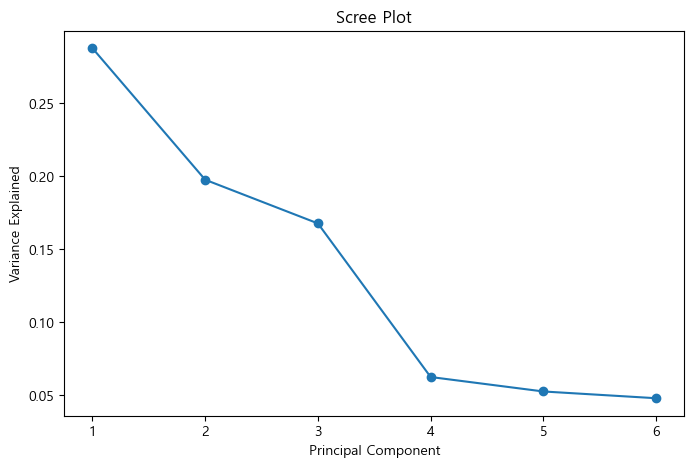

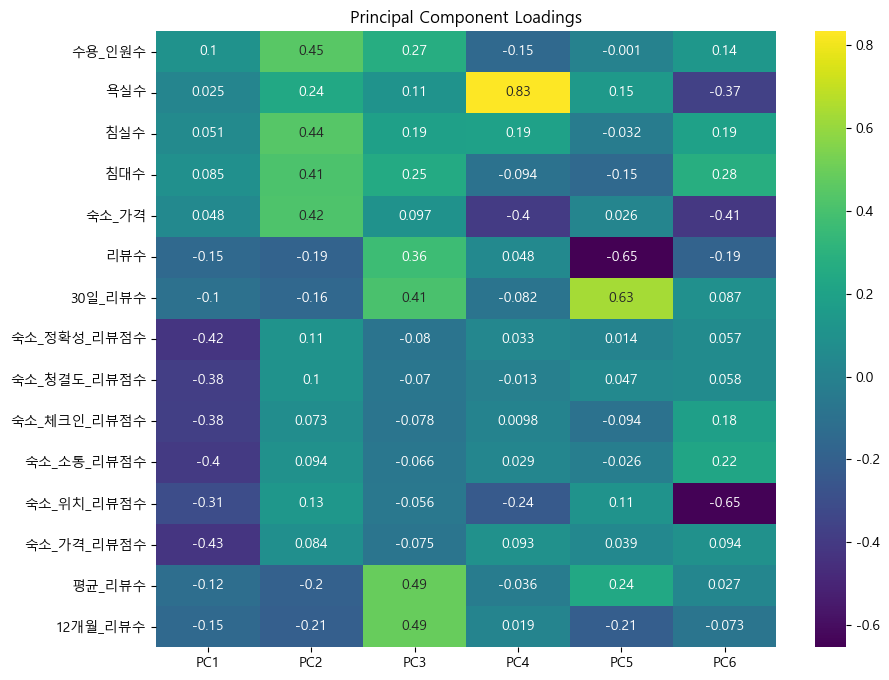

In [17]:

from sklearn.decomposition import PCA

# PCA를 위한 데이터 준비
features = ['수용_인원수', '욕실수', '침실수', '침대수', '숙소_가격', '리뷰수', 
            '30일_리뷰수',  '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', 
            '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수', '숙소_위치_리뷰점수', 
            '숙소_가격_리뷰점수', '평균_리뷰수', '12개월_리뷰수']

x = df[features].values
x = np.nan_to_num(x)  # 결측값이 있는 경우 0으로 대체
x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)  # 데이터 정규화


# PCA 수행
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(x)

# 주성분 데이터프레임 생성
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6'])

# 주성분 분산 비율 출력
print("Explained variance ratio:", pca.explained_variance_ratio_)

# 주성분 부하량(loading) 출력
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6'], index=features)
print("Loadings:")
print(loadings)

# Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# 주성분 상관 관계 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, annot=True, cmap='viridis')
plt.title('Principal Component Loadings')
plt.show()

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import font_manager, rc
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import folium
from folium.plugins import MarkerCluster
from folium import FeatureGroup, LayerControl
from folium.features import GeoJson
from shapely.geometry import shape, Point
import json
from urllib.parse import urlparse, urlunparse, parse_qs, urlencode

# URL에 쿼리 파라미터를 추가하는 함수
def modify_url(url, params):
    url_parts = list(urlparse(url))
    query = dict(parse_qs(url_parts[4]))
    query.update(params)
    url_parts[4] = urlencode(query, doseq=True)
    return urlunparse(url_parts)

# 글꼴 경로 지정
font_path = "c:/Windows/Fonts/malgun.ttf"  # 윈도우에 설치된 맑은 고딕 폰트 경로

# 폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()

# matplotlib의 rc(run command) 기능을 이용하여 글꼴 설정
mpl.rc('font', family=font_name)

# 유니코드에서 음수 부호 설정
mpl.rc('axes', unicode_minus=False)

path = '../../../../../datasets/london_listings.csv'

raw = pd.read_csv(path)
df = raw.copy()

df = df[['id', 'host_id','host_is_superhost',
        'host_total_listings_count','neighbourhood_cleansed','room_type','accommodates','bathrooms','bedrooms',
        'beds','amenities','price','minimum_nights','maximum_nights','number_of_reviews', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 
        'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
        'review_scores_location', 'review_scores_value', 'reviews_per_month','listing_url','property_type','number_of_reviews_ltm','has_availability','last_review']]

df = df.rename(columns= {
    'id': '숙소_id',
    'host_id': '호스트_id',
    'host_is_superhost': '슈퍼호스트',
    'host_total_listings_count': '숙소_수',
    'neighbourhood_cleansed': '숙소_지역',
    'room_type': '숙소_유형',
    'accommodates': '수용_인원수',
    'bathrooms': '욕실수',
    'bedrooms': '침실수',
    'beds': '침대수',
    'amenities': '편의시설',
    'price': '숙소_가격',
    'minimum_nights': '최소_숙박일',
    'maximum_nights': '최대_숙박일',
    'number_of_reviews': '리뷰수',
    'number_of_reviews_l30d': '30일_리뷰수',
    'review_scores_rating': '리뷰점수',
    'review_scores_accuracy': '숙소_정확성_리뷰점수',
    'review_scores_cleanliness': '숙소_청결도_리뷰점수',
    'review_scores_checkin': '숙소_체크인_리뷰점수',
    'review_scores_communication': '숙소_소통_리뷰점수',
    'review_scores_location': '숙소_위치_리뷰점수',
    'review_scores_value': '숙소_가격_리뷰점수',
    'reviews_per_month': '평균_리뷰수',
    'listing_url': 'url',
    'property_type': '숙소_특징',
    'number_of_reviews_ltm': '12개월_리뷰수',
    'has_availability': '예약가능여부',
    'last_review': '마지막_리뷰'
})
df['위도'] = raw['latitude']
df['경도'] = raw['longitude']

# 결측치 및 필터링
df = df.dropna(subset=['슈퍼호스트', '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수', '숙소_위치_리뷰점수', '숙소_가격_리뷰점수'])
df = df[df['리뷰수'] > 2]
df = df[(df['숙소_유형'] == 'Entire home/apt') | (df['숙소_유형'] == 'Private room')]
df = df[df['12개월_리뷰수'] != 0]

# 숙소 가격을 숫자로 변환
df['숙소_가격'] = df['숙소_가격'].replace('[\$,]', '', regex=True).astype(float)

# 이상치 제거 함수
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    return filtered_df

df = remove_outliers(df, '숙소_가격')
df = remove_outliers(df, '욕실수')
df = remove_outliers(df, '침실수')
df = remove_outliers(df, '침대수')

# 로그 변환
cols_to_log_transform = ['리뷰수', '12개월_리뷰수', '30일_리뷰수', '숙소_가격', '평균_리뷰수']
df[cols_to_log_transform] = df[cols_to_log_transform].apply(lambda x: np.log1p(x))

# PCA를 위한 데이터 준비
features = ['수용_인원수', '욕실수', '침실수', '침대수', '숙소_가격', '리뷰수', 
            '30일_리뷰수', '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', 
            '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수', '숙소_위치_리뷰점수', 
            '숙소_가격_리뷰점수', '평균_리뷰수', '12개월_리뷰수']

# 스케일링
x = df[features].values
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)


Explained variance ratio: [0.28749029 0.19754481 0.16765363 0.06259821 0.05271179 0.0480947 ]
Cumulative explained variance ratio: [0.28749029 0.4850351  0.65268873 0.71528694 0.76799873 0.81609343]
Loadings:
                  PC1       PC2       PC3       PC4       PC5       PC6
수용_인원수       0.100448  0.445907  0.272662 -0.153175 -0.001033  0.136071
욕실수          0.024989  0.237940  0.108098  0.834181  0.146480 -0.366559
침실수          0.050564  0.439580  0.186426  0.193170 -0.032310  0.192794
침대수          0.085326  0.413418  0.252917 -0.094364 -0.153340  0.277667
숙소_가격        0.047956  0.417344  0.097131 -0.395564  0.026020 -0.410826
리뷰수         -0.153709 -0.185183  0.363365  0.048409 -0.653711 -0.187418
30일_리뷰수     -0.104700 -0.159349  0.405441 -0.082068  0.632002  0.086816
숙소_정확성_리뷰점수 -0.424273  0.111019 -0.079495  0.032855  0.014002  0.057400
숙소_청결도_리뷰점수 -0.384300  0.104699 -0.069831 -0.013187  0.047099  0.058125
숙소_체크인_리뷰점수 -0.378247  0.072702 -0.077988  0.009778 -0.094273  0.179881

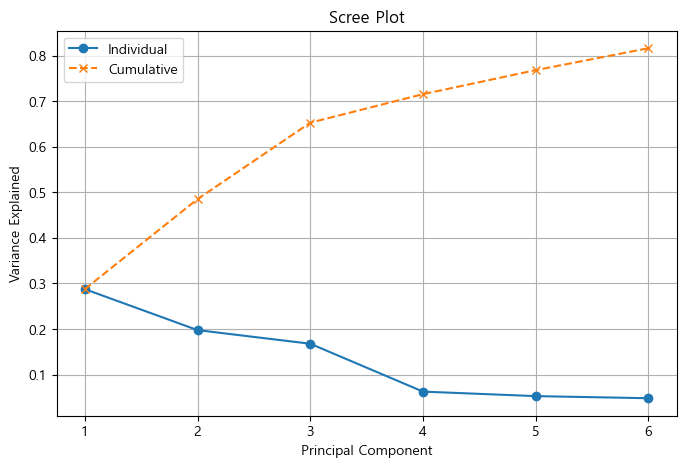

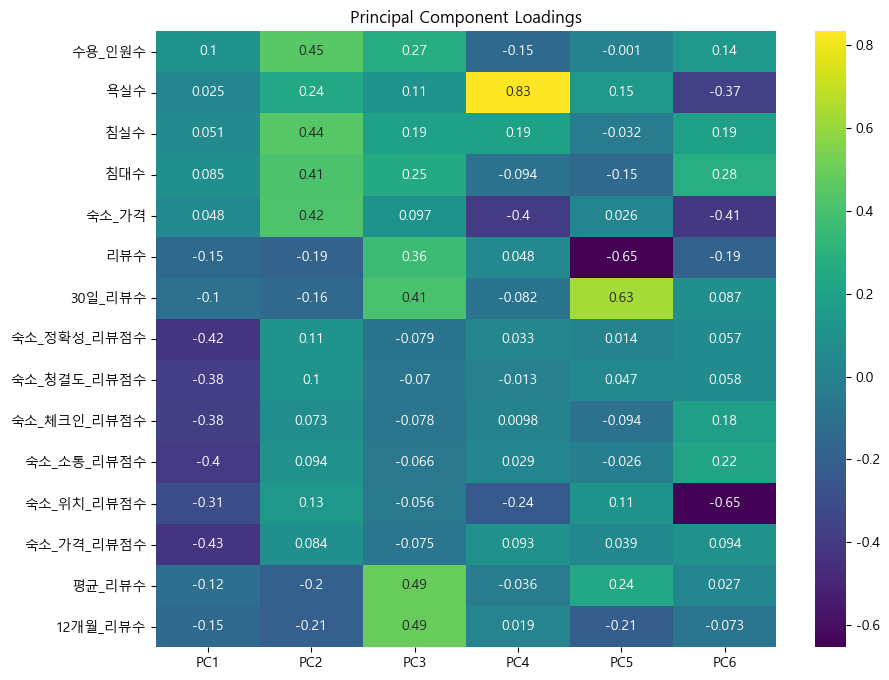

In [26]:

# PCA 수행
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(x_scaled)

# 주성분 데이터프레임 생성
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6'])

# 주성분 분산 비율 출력
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()
print("Explained variance ratio:", explained_variance_ratio)
print("Cumulative explained variance ratio:", cumulative_variance_ratio)

# 주성분 부하량(loading) 출력
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], index=features)
print("Loadings:")
print(loadings)

# Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='x', linestyle='--', label='Cumulative')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

# 주성분 상관 관계 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, annot=True, cmap='viridis')
plt.title('Principal Component Loadings')
plt.show()


                            OLS Regression Results                            
Dep. Variable:                   리뷰점수   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                 3.523e+04
Date:                Tue, 11 Jun 2024   Prob (F-statistic):               0.00
Time:                        21:21:51   Log-Likelihood:                 17593.
No. Observations:               26568   AIC:                        -3.518e+04
Df Residuals:                   26563   BIC:                        -3.513e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7190      0.001   6163.246      0.0

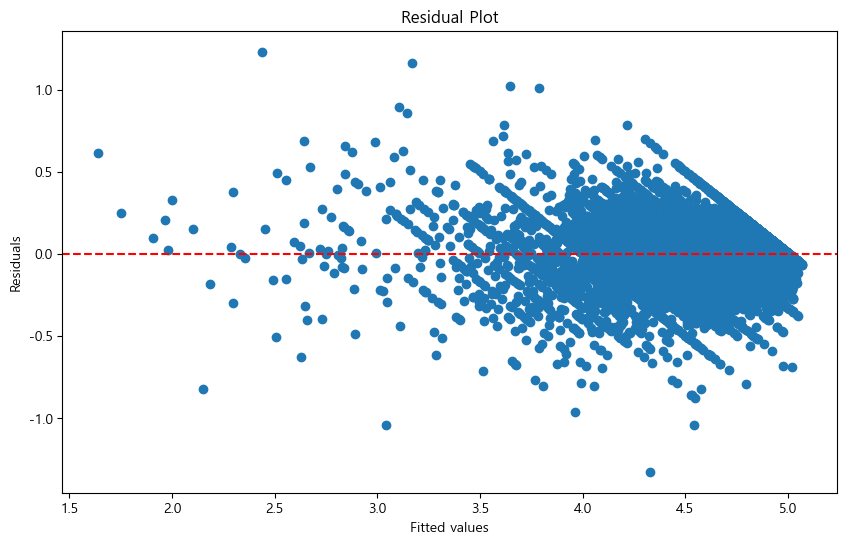

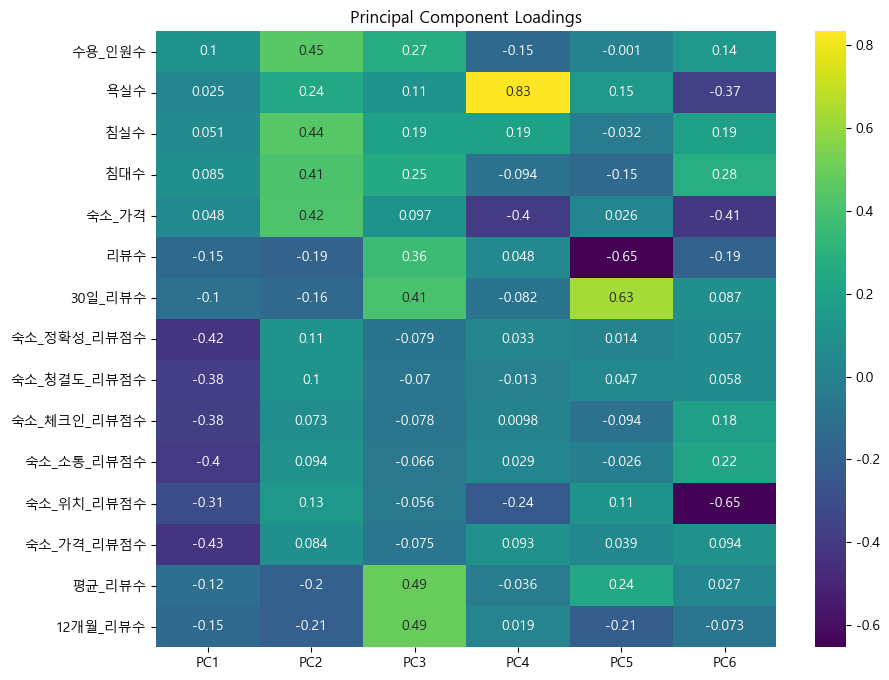

In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
# 스케일링
x = df[features].values
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# PCA 수행
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x_scaled)

# 주성분 데이터프레임 생성
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3', 'PC4'])

# 리뷰점수 추가
pca_df['리뷰점수'] = df['리뷰점수'].values

# 다중 회귀 분석
X = pca_df[['PC1', 'PC2', 'PC3', 'PC4']]
y = pca_df['리뷰점수']
X = sm.add_constant(X)  # 상수항 추가
model = sm.OLS(y, X).fit()

# 회귀 분석 결과 출력
print(model.summary())

# 잔차 플롯
residuals = model.resid
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import font_manager, rc
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import folium
from folium.plugins import MarkerCluster
from folium import FeatureGroup, LayerControl
from folium.features import GeoJson
from shapely.geometry import shape, Point
import json
from urllib.parse import urlparse, urlunparse, parse_qs, urlencode

# URL에 쿼리 파라미터를 추가하는 함수
def modify_url(url, params):
    url_parts = list(urlparse(url))
    query = dict(parse_qs(url_parts[4]))
    query.update(params)
    url_parts[4] = urlencode(query, doseq=True)
    return urlunparse(url_parts)

# 글꼴 경로 지정
font_path = "c:/Windows/Fonts/malgun.ttf"  # 윈도우에 설치된 맑은 고딕 폰트 경로

# 폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()

# matplotlib의 rc(run command) 기능을 이용하여 글꼴 설정
mpl.rc('font', family=font_name)

# 유니코드에서 음수 부호 설정
mpl.rc('axes', unicode_minus=False)

path = '../../../../../datasets/paris_listings.csv'

raw = pd.read_csv(path)
df = raw.copy()

df = df[['id', 'host_id','host_is_superhost',
        'host_total_listings_count','neighbourhood_cleansed','room_type','accommodates','bathrooms','bedrooms',
        'beds','amenities','price','minimum_nights','maximum_nights','number_of_reviews', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 
        'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
        'review_scores_location', 'review_scores_value', 'reviews_per_month','listing_url','property_type','number_of_reviews_ltm','has_availability','last_review']]

df = df.rename(columns= {
    'id': '숙소_id',
    'host_id': '호스트_id',
    'host_is_superhost': '슈퍼호스트',
    'host_total_listings_count': '숙소_수',
    'neighbourhood_cleansed': '숙소_지역',
    'room_type': '숙소_유형',
    'accommodates': '수용_인원수',
    'bathrooms': '욕실수',
    'bedrooms': '침실수',
    'beds': '침대수',
    'amenities': '편의시설',
    'price': '숙소_가격',
    'minimum_nights': '최소_숙박일',
    'maximum_nights': '최대_숙박일',
    'number_of_reviews': '리뷰수',
    'number_of_reviews_l30d': '30일_리뷰수',
    'review_scores_rating': '리뷰점수',
    'review_scores_accuracy': '숙소_정확성_리뷰점수',
    'review_scores_cleanliness': '숙소_청결도_리뷰점수',
    'review_scores_checkin': '숙소_체크인_리뷰점수',
    'review_scores_communication': '숙소_소통_리뷰점수',
    'review_scores_location': '숙소_위치_리뷰점수',
    'review_scores_value': '숙소_가격_리뷰점수',
    'reviews_per_month': '평균_리뷰수',
    'listing_url': 'url',
    'property_type': '숙소_특징',
    'number_of_reviews_ltm': '12개월_리뷰수',
    'has_availability': '예약가능여부',
    'last_review': '마지막_리뷰'
})
df['위도'] = raw['latitude']
df['경도'] = raw['longitude']

# 결측치 및 필터링
df = df.dropna(subset=['슈퍼호스트', '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수', '숙소_위치_리뷰점수', '숙소_가격_리뷰점수'])
df = df[df['리뷰수'] > 2]
df = df[(df['숙소_유형'] == 'Entire home/apt') | (df['숙소_유형'] == 'Private room')]
df = df[df['12개월_리뷰수'] != 0]

# 숙소 가격을 숫자로 변환
df['숙소_가격'] = df['숙소_가격'].replace('[\$,]', '', regex=True).astype(float)

# 이상치 제거 함수
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    return filtered_df

df = remove_outliers(df, '숙소_가격')
df = remove_outliers(df, '욕실수')
df = remove_outliers(df, '침실수')
df = remove_outliers(df, '침대수')

# 로그 변환
cols_to_log_transform = ['리뷰수', '12개월_리뷰수', '30일_리뷰수', '숙소_가격', '평균_리뷰수']
df[cols_to_log_transform] = df[cols_to_log_transform].apply(lambda x: np.log1p(x))

# PCA를 위한 데이터 준비
features = ['수용_인원수', '욕실수', '침실수', '침대수', '숙소_가격', '리뷰수', 
            '30일_리뷰수', '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', 
            '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수', '숙소_위치_리뷰점수', 
            '숙소_가격_리뷰점수', '평균_리뷰수', '12개월_리뷰수']

# 스케일링
x = df[features].values
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)


Explained variance ratio: [0.30152361 0.20661068 0.13806888 0.07037595 0.06261311 0.05326574]
Cumulative explained variance ratio: [0.30152361 0.5081343  0.64620317 0.71657912 0.77919223 0.83245797]
Loadings:
                      PC1           PC2           PC3           PC4  \
수용_인원수       7.136705e-02  1.351862e-01  6.200701e-01 -2.605381e-01   
욕실수          5.551115e-17 -1.665335e-16  0.000000e+00  1.006140e-16   
침실수         -2.220446e-16 -5.551115e-17  1.665335e-16 -2.775558e-17   
침대수          6.536055e-02  1.343195e-01  5.910652e-01 -3.306495e-01   
숙소_가격       -7.314007e-02 -4.005615e-02  4.752674e-01  6.229416e-01   
리뷰수         -8.139411e-02  4.321492e-01 -1.953308e-02  2.354668e-01   
30일_리뷰수     -5.541931e-02  4.314821e-01 -1.119628e-01 -1.834301e-01   
숙소_정확성_리뷰점수 -4.465159e-01 -7.175856e-02  3.013631e-02 -6.607323e-02   
숙소_청결도_리뷰점수 -3.960726e-01 -1.194786e-02  3.992835e-02  2.386164e-02   
숙소_체크인_리뷰점수 -3.940928e-01 -5.233765e-02 -3.166642e-03 -2.250027e-01   
숙소_소통_리뷰점수

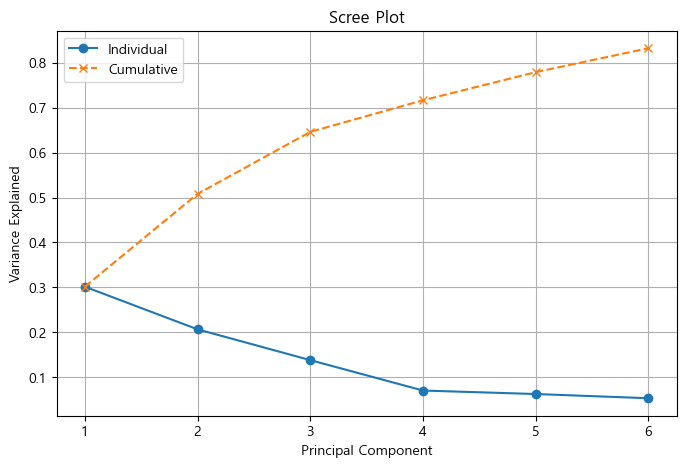

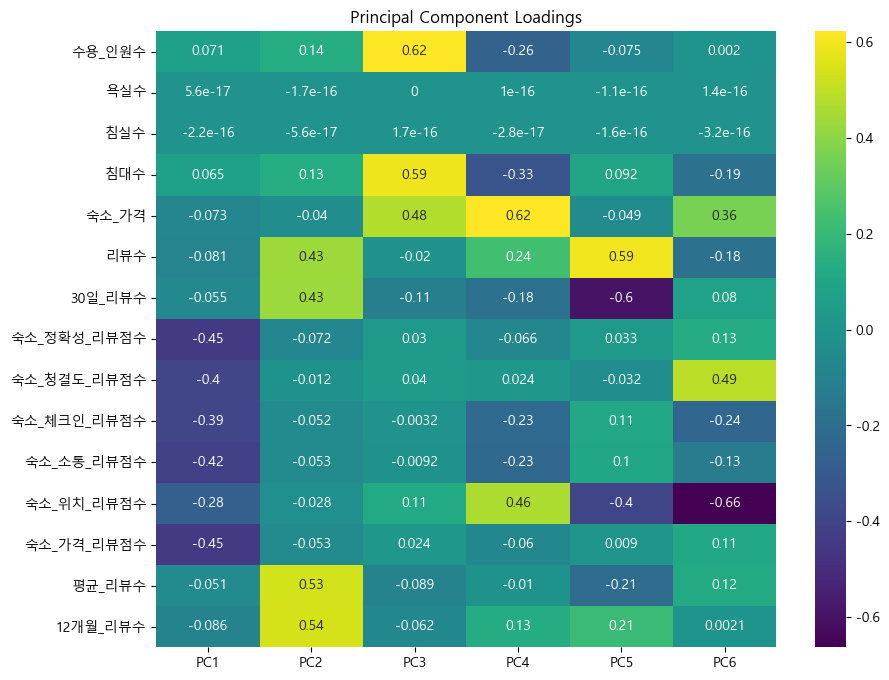

In [31]:

# PCA 수행
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(x_scaled)

# 주성분 데이터프레임 생성
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6'])

# 주성분 분산 비율 출력
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()
print("Explained variance ratio:", explained_variance_ratio)
print("Cumulative explained variance ratio:", cumulative_variance_ratio)

# 주성분 부하량(loading) 출력
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], index=features)
print("Loadings:")
print(loadings)

# Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='x', linestyle='--', label='Cumulative')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

# 주성분 상관 관계 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, annot=True, cmap='viridis')
plt.title('Principal Component Loadings')
plt.show()
